# Libraries

In [1]:
generate_data = False
save_to_cloud = True
bucket_address = "s3://verafin-mitacs-ruben-chevez/"
project_folder = "customer_batches"
model_name     = "customer_batches_rnn_best_model.h5"
project_path   = bucket_address + project_folder 

#General
import json
import zipfile
import os
import math
import time
import progressbar
import pickle
import s3fs

#Math & Visualization
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline 
import seaborn as sns
sns.set()

# Oversampling
from imblearn.over_sampling import SMOTE

## Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold , StratifiedKFold

## Models
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping,  ModelCheckpoint

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [3]:
!pwd

# To List 5 files in your accessible bucket
s3fs.S3FileSystem().ls(project_path)[:5]

/home/ec2-user/SageMaker


['verafin-mitacs-ruben-chevez/customer_batches/data',
 'verafin-mitacs-ruben-chevez/customer_batches/images',
 'verafin-mitacs-ruben-chevez/customer_batches/models']

# Import Dataset From Kaggle

In [4]:
# !rm -rf /root/.kaggle
# !mkdir /root/.kaggle

!rm -rf /home/ec2-user/.kaggle
!mkdir /home/ec2-user/.kaggle
api_token = {"username":"rubencg195","key":"1a0667935c03c900bf8cc3b4538fa671"}
# with open('/root/.kaggle/kaggle.json', 'w') as file:
with open('/home/ec2-user/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

# !chmod 600 /root/.kaggle/kaggle.json
!chmod 600 /home/ec2-user/.kaggle/kaggle.json

!kaggle datasets download -d ntnu-testimon/banksim1 --force

/bin/sh: kaggle: command not found


In [5]:
# zipFilePath = "/content/banksim1.zip" 
zipFilePath = "/home/ec2-user/SageMaker/banksim1.zip"
zip_ref = zipfile.ZipFile(zipFilePath, 'r')
zip_ref.extractall()
zip_ref.close()

In [6]:
!ls -la 

total 205332
drwxr-xr-x  7 ec2-user ec2-user     4096 Feb 12 04:15 .
drwx------ 23 ec2-user ec2-user     4096 Feb 12 13:35 ..
-rw-rw-r--  1 ec2-user ec2-user   520078 Feb 11 19:27 2-RNN_Fraud_Detection_tests.ipynb
-rw-rw-r--  1 ec2-user ec2-user 13712256 Feb 11 19:45 banksim1.zip
-rw-rw-r--  1 ec2-user ec2-user     1814 Feb 12 01:39 BOX_PLOT_SHOWING_SIZES_OF_BATCHES_GROUPED_BY_CUSTOMER_ID_generating3DRNNInput.png
-rw-rw-r--  1 ec2-user ec2-user 48986035 Feb 12 13:35 bs140513_032310.csv
-rw-rw-r--  1 ec2-user ec2-user 32665953 Feb 12 13:35 bsNET140513_032310.csv
-rw-rw-r--  1 ec2-user ec2-user     1814 Feb 12 01:39 FEATURE_IMPORTANCE_normalizing_data.png
-rw-rw-r--  1 ec2-user ec2-user     1814 Feb 12 01:39 FRAUD_PERCENTAGE_AT_DIFFERENT_RANGES_OF_TRANSACTION_AMOUNT_visualize_data.png
-rw-rw-r--  1 ec2-user ec2-user     1814 Feb 12 01:39 FRAUD_VS_NONFRAUD_HISTOGRAM_visualize_data.png
-rw-rw-r--  1 ec2-user ec2-user     1814 Feb 12 01:39 FREQUENCY_DISTRIBUTION_OF_TRANSACTION_AMOUNTS_visua

# Data Visualization


In [7]:
def read_data(input_file_path):
  print("\n\n{} {} {}\n\n".format( 10*"_ " , "IMPORT DATA FROM CSV" , 10*"_ "))
  data = pd.read_csv(input_file_path)
  print("Deleting the columns 'zipcodeOri','zipMerchant' because all the fields are equal.\n\n")
  del data['zipcodeOri']
  del data['zipMerchant']
  print("Data Shape: {} \n\nPreview: \n\n {} \n\n Data Information: \n".format( data.shape, data.head() ))
  print("\n{}\nDoes it has null values? {}".format(data.info(), data.isnull().values.any() ))
  return data

def visualize_data(data):
  print("\n\n{} {} {}\n\n".format( 10*"_ " , "PIE CHART - FRAUD VS NON-FRAUD" , 10*"_ "))
  df_fraud= data[data['fraud']==1]
  num_transaction_total, num_transaction_fraud = len(data), len(df_fraud)
  num_transaction_total, num_transaction_fraud
  print("Total Transactions: {} \nTotal Fraud Transactions: {}".format(num_transaction_total, num_transaction_fraud) )
  percent_fraud = round((num_transaction_fraud / num_transaction_total) * 100, 2)
  percent_safe = 100 - percent_fraud
  percent_fraud, percent_safe
  print("% Safe Transactions: {} \n% Fraud Transactions: {}\n\n".format(percent_safe, percent_fraud) ) # plotting pie chart for percentage comparision: 'fraud' vs 'safe-transaction'
  fig1, ax1 = plt.subplots()
  plt.title("Figure 1. Fraud vs Safe Transaction in Percentage", fontsize = 20)
  labels = ['Fraud', 'Safe Transaction']
  sizes = [percent_fraud, percent_safe]
  explode = (0, 0.7)  # only "explode" the 2nd slice (i.e. 'Hogs')
  patches, texts, autotexts = ax1.pie(sizes,  labels=labels, autopct='%1.1f%%', shadow = True, explode=explode, startangle=130, colors = ['#ff6666', '#2d64bc'])
  texts[0].set_fontsize(30)
  texts[1].set_fontsize(18)
  matplotlib.rcParams['text.color'] = 'black'
  matplotlib.rcParams["font.size"] = 30
  plt.rcParams["figure.figsize"] = [6, 6]
  plt.show()
  plt.savefig('PIE_CHART_FRAUD_VS_NONFRAUD_visualize_data.png')

  print("\n\n{} {} {}\n\n".format( 10*"_ " , "COLUMN INFORMATION & PREVIEW" , 10*"_ "))
  # Extracting # of unique entires per column and their sample values
  num_unique = []
  sample_col_values = []
  for col in data.columns:
      num_unique.append(len(data[col].unique()))  # Counting number of unique values per each column
      sample_col_values.append(data[col].unique()[:3])  # taking 3 sample values from each column   
  # combining the sample values into a a=single string (commas-seperated)
  # ex)  from ['hi', 'hello', 'bye']  to   'hi, hello, bye'
  col_combined_entries = []
  for col_entries in sample_col_values:
      entry_string = ""
      for entry in col_entries:
          entry_string = entry_string + str(entry) + ', '
      col_combined_entries.append(entry_string[:-2])
  # Generating a list 'param_nature' that distinguishes features and targets
  param_nature = []
  for col in data.columns:
      if col == 'fraud':
          param_nature.append('Target')
      else:
          param_nature.append('Feature')
  # Generating Table1. Parameters Overview
  df_feature_overview = pd.DataFrame(np.transpose([param_nature, num_unique, col_combined_entries]), index = data.columns, columns = ['Parameter Nature', '# of Unique Entries', 'Sample Entries (First three values)'])
  print("\nTotal # of Values: {} \nShape: {} \n\n".format(len(data), data.shape))
  print(df_feature_overview)

  print("\n\n{} {} {}\n\n".format( 10*"_ " , "FRAUD VS NON-FRAUD AVE. AMOUNT & PERCENTAGE" , 10*"_ "))
  df_fraud     = data.loc[data.fraud == 1] 
  df_non_fraud = data.loc[data.fraud == 0]
  fraud_ave_amount_col          = df_fraud.groupby('category')['amount'].mean().round(2)
  non_fraud_ave_amount_col      = df_non_fraud.groupby('category')['amount'].mean().round(2)
  percentage_fraud_per_category = data.groupby('category')['fraud'].mean().round(3)*100
  amount_percentage_table       = pd.concat(
      [ fraud_ave_amount_col , non_fraud_ave_amount_col, percentage_fraud_per_category ],
      keys=["Fraudulent Ave. Amount","Non-Fraudulent Ave. Amount","Fraud Percent(%)"],
      axis=1, 
      sort=False
  ).sort_values(by=['Non-Fraudulent Ave. Amount'])
  print(amount_percentage_table)
  num_bins = 15                 # Number of sections where data will be segmented to be shown as a bar in the histogram. For example: The first bin is called "0~500"
  tran_amount = data['amount']
  n, bins, patches = plt.hist(tran_amount, num_bins, density = False, stacked = True, facecolor= '#f26a6a', alpha=0.5)
  plt.close()
  n_fraud = np.zeros(num_bins)
  for i in range(num_bins):
      for j in range(num_transaction_fraud):
          if bins[i] < df_fraud['amount'].iloc[j] <= bins[i+1]:  #??????
              n_fraud[i] += 1
  range_amount = []
  for i in range(num_bins):
      lower_lim, higher_lim = str(int(bins[i])), str(int(bins[i+1]))
      range_amount.append("$ " + lower_lim + " ~ " + higher_lim )
  df_hist = pd.DataFrame(index = range_amount)
  df_hist.index.name = 'Transaction Amount[$]'
  df_hist['# Total'] = n
  df_hist['# Fraud'] = n_fraud
  df_hist['# Safe'] = df_hist['# Total'] - df_hist['# Fraud']
  df_hist['% Fraud'] = (df_hist['# Fraud'] / df_hist['# Total'] * 100).round(2)
  df_hist['% Safe'] = (df_hist['# Safe'] / df_hist['# Total'] * 100).round(2)
  print(df_hist)

  print("\n\n{} {} {}\n\n".format( 10*"_ " , "FREQUENCY DISTRIBUTION OF TRANSACTION AMOUNTS" , 10*"_ "))  
  fig3 = plt.figure(figsize=(16,6))
  # Generating stacked bar-chart
  bars_fraud = plt.bar(range(num_bins), df_hist['# Safe'], width = 0.5, color = '#00e64d')
  bars_safe = plt.bar(range(num_bins), df_hist['# Fraud'], width = 0.5, bottom = df_hist['# Safe'], color='#ff6666')
  # Labeling
  plt.title("Figure 3. Frequency Distribution of Transaction Amount", fontsize = 20)
  plt.xticks(range(num_bins), range_amount, fontsize = 14)
  plt.yticks(fontsize = 14)
  plt.legend((bars_fraud[0], bars_safe[0]), ('Safe Transaction', 'Fraud'), loc=4, fontsize = 16)
  plt.xlabel('Ranges of Transaction Amount', fontsize=16)
  plt.ylabel('Number of Occurence', fontsize=16)
  # hiding top/right border
  ax = plt.gca()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  x = plt.gca().xaxis
  # rotate the tick labels for the x axis
  for item in x.get_ticklabels():
      item.set_rotation(50)
  plt.show()
  plt.savefig('FREQUENCY_DISTRIBUTION_OF_TRANSACTION_AMOUNTS_visualize_data.png')

  print("\n\n{} {} {}\n\n".format( 10*"_ " , "FRAUD PERCENTAGE AT DIFFERENT RANGES OF TRANSACTION AMOUNT" , 10*"_ "))  
  fig4 = plt.figure(figsize=(16,6))
  # Generating stacked bar-chart
  bars_fraud = plt.bar(range(num_bins), df_hist['% Safe'], width = 0.5, color = '#00e64d')
  bars_safe = plt.bar(range(num_bins), df_hist['% Fraud'], width = 0.5, bottom = df_hist['% Safe'], color='#ff6666')
  # Labeling
  plt.title("Figure 4. Fraud Percentage at Different Ranges of Transaction Amount", fontsize = 20)
  plt.xticks(range(num_bins), range_amount, fontsize = 14)
  plt.yticks(fontsize = 14)
  plt.legend((bars_fraud[0], bars_safe[0]), ('Safe Transaction', 'Fraud'), loc=4, fontsize = 16)
  plt.xlabel('Ranges of Transaction Amount', fontsize=16)
  plt.ylabel('Percentage', fontsize=16)
  plt.ylim(0, 100)
  x = plt.gca().xaxis
  # rotate the tick labels for the x axis
  for item in x.get_ticklabels():
      item.set_rotation(85)
  # hiding top/right border
  ax = plt.gca()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)    
  # bar-value display
  for bar in bars_safe:
      plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 5, str(int(bar.get_height())) + '%', 
                  ha='center', color='w', fontsize=13, rotation = 'vertical', weight = 'bold')
  plt.gca().text(bars_fraud[0].get_x() + bars_fraud[0].get_width()/2, bars_fraud[0].get_height() - 5, str(int(bars_fraud[0].get_height())) + '%', 
                  ha='center', color='black', fontsize=13, rotation = 'vertical', weight = 'bold')
  plt.show()
  plt.savefig('FRAUD_PERCENTAGE_AT_DIFFERENT_RANGES_OF_TRANSACTION_AMOUNT_visualize_data.png')

  print("\n\n{} {} {}\n\n".format( 10*"_ " , "FRAUD VS NON-FRAUD HISTOGRAM" , 10*"_ "))  
  plt.figure(figsize=(30,10))
  sns.boxplot(x=data['category'],y=data.amount)
  plt.title("Boxplot for the Amount spend in category")
  plt.ylim(0,4000)
  plt.legend()
  plt.show()
  plt.savefig('FRAUD_VS_NONFRAUD_HISTOGRAM_visualize_data.png')

  print("\n\n{} {} {}\n\n".format( 10*"_ " , "FRAUD DISTRIBUTION PER AGE" , 10*"_ "))  
  age_comparison_df = df_fraud.groupby('age')['fraud'].agg(['count']).reset_index().rename(columns={'age':'Age','count' : '# of Fraud'}).sort_values(by='# of Fraud')
  age_df = pd.DataFrame([ ["'0'", "<=18"], ["'1'", "19-25"], ["'2'", "26-35"], ["'3'", "36-45"], ["'4'", "46-55"], ["'5'", "56-65"], ["'6'", ">65"], ["'U'", "Unknown"], ], columns=["Age", "Label"])
  age_comparison_df = pd.merge(age_comparison_df, age_df, on="Age", how="outer")
  age_comparison_df['Age'] = age_comparison_df['Age'].map(lambda x: x.strip("'"))
  age_comparison_df = age_comparison_df.sort_index(by=["Age"])
  age_comparison_df = age_comparison_df[["Age", "Label", '# of Fraud']]
  print(age_comparison_df)
    

def normalizing_data(data):
  # Generate Hash Maps to be able to convert from numerical to categorical later.
  print("\n\n{} {} {}\n\n".format( 10*"_ " , "CATEGORICAL VALUES TO NUMERICAL - HASHMAP GENERATION" , 10*"_ "))
  tmp_df = data[:]
  col_categorical = tmp_df.select_dtypes(include= ['object']).columns
  print( "Features Types: \n\n{}\n\n".format(tmp_df.dtypes) )
  print( "Categorical Features: {}\n\n".format(col_categorical) )
  print( "\nHash maps previews:\n" )
  labels_hash = dict()
  for col_name in col_categorical:                         
    tmp_df[col_name] = tmp_df[col_name].astype('category') 
    labels_hash[col_name] = pd.DataFrame(  zip( tmp_df[col_name].cat.codes, tmp_df[col_name] ) , columns=["Index", "Label"] ).drop_duplicates(subset=['Index'])
    print("{} {} {} \n {}".format(10*"_", col_name , 10*"_", labels_hash[col_name].head() ) )
  # Converting categorical entries to integers
  tmp_df[col_categorical] = tmp_df[col_categorical].apply(lambda x: x.cat.codes)
  # seperatign data columns and target columns
  col_names = tmp_df.columns.tolist()
  col_names_features = col_names[0:len(col_names)-1]
  col_name_label     = col_names[-1]
  # Declaring 'data-dataframe'  and 'target-dataframe'
  X = tmp_df[col_names_features]
  y = tmp_df[col_name_label]

  print("\n\n{} {} {}\n\n".format( 10*"_ " , "FEATURE IMPORTANCE" , 10*"_ "))
  dt = DecisionTreeClassifier()
  print("\n\n{}\n\n".format(dt))
  dt.fit(X, y)
  # sorted-feature importances from the preliminary decision tree 
  ds_fi = pd.Series(dt.feature_importances_ , index = col_names_features).sort_values(ascending= False)
  # plotting feature imporance bar-graph
  fig2 = plt.figure(figsize=(13,5))
  # Generating stacked bar-chart
  bars_ft = plt.bar(range(len(ds_fi)), ds_fi, width = .8, color = '#2d64bc')
  # Labeling
  ttl = plt.title("Figure 2. Feature Importances", fontsize = 20).set_position([0.45, 1.1])
  plt.xticks(range(len(ds_fi)), ds_fi.index, fontsize = 14)
  # plot-dejunking
  ax = plt.gca()
  ax.yaxis.set_visible(False) # hide entire y axis (both ticks and labels)
  ax.xaxis.set_ticks_position('none')  # hide only the ticks and keep the label
  plt.xticks(rotation='vertical')
  # hide the frame
  for spine in plt.gca().spines.values():
    spine.set_visible(False)
  # value displaying
  rects = ax.patches  
  labels = ds_fi.values.round(2)
  for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom', fontsize = 13)
  
  plt.show()
  plt.savefig('FEATURE_IMPORTANCE_normalizing_data.png')
  return labels_hash

# Pre-processing

In [8]:
def generating3DRNNInput(data):
  tmp_df = data[:]
  col_categorical        = tmp_df.select_dtypes(include= ['object']).columns
  for col_name in col_categorical:                         #????
    tmp_df[col_name] = tmp_df[col_name].astype('category') 
  tmp_df[col_categorical]  = tmp_df[col_categorical].apply(lambda x: x.cat.codes)
  X = tmp_df.iloc[:, :-1]
  y = tmp_df.fraud
  print("\n\n{} {} {}\n\n".format( 10*"_ " , "VISUALIZATION BEFORE TRANSFORMATION" , 10*"_ "))
  print("Total Fraud vs Non-Fraud Transactions Count: \n\n{}\n".format(y.value_counts()))
  print("Number of customers: ",  X["customer"].nunique() )
  print("Ratio of positive frauds vs total dataset: {:0.2f}%".format( ( y[y==1].count() /len(X)) *100  ))
  # The RNNs requiere various a 3D input of groups of less of 300 samples per group for better performance. One option is to divide the datasets per day. 
  # Even by dividing per day, each day has more than 7K data points per data group.
  mean_samples_per_customer = X["customer"].value_counts().mean()
  max_samples_per_customer = X["customer"].value_counts().max()
  print("\nTransactions per customer.\n\tMean: {:0.1f}\n\tMax:  {:0.0f} \n\tNumber of Batches Using Max Amount as Fixed Size: {:0.1f} ~ {}\n\tNumber of Batches Using Mean Amount as Fixed Size: {:0.1f} ~ {}".format(
      mean_samples_per_customer, 
      max_samples_per_customer, 
      len(X) / max_samples_per_customer ,
      math.ceil(len(X) / max_samples_per_customer ),
      len(X) / mean_samples_per_customer ,
      math.ceil(len(X) / mean_samples_per_customer )
  ))
  mean_samples_per_day = X["step" ].value_counts().mean()
  max_samples_per_day = X["step"].value_counts().max()
  print("\n\nSamples per Step (day): \n\tMean: {:0.0f} \n\tMax: {} \n\tNumber of Batches Using Max Amount as Fixed Size: {:0.1f} ~ {}\n\tNumber of Batches Using Mean Amount as Fixed Size: {:0.1f} ~ {}".format(
    mean_samples_per_day, max_samples_per_day, 
    len(X) / max_samples_per_day ,
    math.ceil(len(X) / max_samples_per_day ),
    len(X) / mean_samples_per_day ,
    math.ceil(len(X) / mean_samples_per_day )
  ))

  print("\n\n{} {} {}\n\n".format( 10*"_ " , "GROUPING TRANSACTIONS BY CUSTOMER ID" , 10*"_ "))
  customer_batches = dict()
  count = 0
  for x in tmp_df.groupby(["customer"]):
    customer_batches[x[0]] = x[1] 
  min_trans_per_cust = np.min( [ customer_batches[i].shape[0] for i in customer_batches]  ) 
  mean_trans_per_cust = np.mean( [ customer_batches[i].shape[0] for i in customer_batches]  ) 
  max_trans_per_cust = np.max( [ customer_batches[i].shape[0] for i in customer_batches]  ) 
  n_features =  tmp_df.shape[1]
  print("LEN: ", len(customer_batches))
  print("# Feaures: ", n_features )
  print("MIN TRANS PER CUST: ", min_trans_per_cust )
  print("MEAN TRANS PER CUST: ", mean_trans_per_cust, " ~ ", math.ceil(mean_trans_per_cust) )
  print("MAX TRANS PER CUST: ", max_trans_per_cust)
  print("EXAMPLE: \n\n", customer_batches[0] )

  # See how many groups of customer transactions are above the average size of 145
  print("\n\nSCATTER PLOT SHOWING SIZES OF BATCHES GROUPED BY CUSTOMER ID: \n\n" )
  fig=plt.figure()
  ax=fig.add_axes([0,0,1,1])
  ax.scatter(range(4112), [ customer_batches[i].shape[0] for i in customer_batches] , color='r')
  ax.plot([0, 4112], [145, 145], "--")
  ax.set_xlabel('Batch Index')
  ax.set_ylabel('Batch Size')
  ax.set_title('Customer Batches Sizes')
  plt.show()
  plt.savefig('SCATTER_PLOT_SHOWING_SIZES_OF_BATCHES_GROUPED_BY_CUSTOMER_ID_generating3DRNNInput.png')

  print("\n\nBOX PLOT SHOWING MEAN SIZE OF BATCHES GROUPED BY CUSTOMER ID: \n\n" )
  fig1, ax1 = plt.subplots()
  ax1.set_title('Batch Sizes')
  ax1.boxplot([ customer_batches[i].shape[0] for i in customer_batches],  vert=False)
  plt.show()
  plt.savefig('BOX_PLOT_SHOWING_SIZES_OF_BATCHES_GROUPED_BY_CUSTOMER_ID_generating3DRNNInput.png')

  print("\n\n{} {} {}\n\n".format( 10*"_ " , "GENERATING 3D INPUT WITH BATCHES OF SIZE "+str(max_trans_per_cust) , 10*"_ "))
  # Full 3D Array as an input for the LSTM
  # empty_padding_value = -1
  empty_padding_value = 0
  np_customer_batches = list()
  total_empty_rows_added = 0
  for k in customer_batches:
    empty_rows_to_add =  max_trans_per_cust - customer_batches[k].shape[0]
    z = np.full( ( empty_rows_to_add , n_features ), empty_padding_value )
    np_customer_batches.append( np.r_[ customer_batches[k].values , z] )
    total_empty_rows_added += empty_rows_to_add
  np_customer_batches_3d = np.array(np_customer_batches)
  mean_frauds_per_batch       = np.mean( [ len(b[-1][b[-1] == 1 ]) for b in np_customer_batches_3d ]  )  
  percentage_frauds_per_batch = np.mean( [ len(b[-1][b[-1] == 1 ]) / max_trans_per_cust for b in np_customer_batches_3d ]  )  * 100
  print(
      """
      The batches are separated by customer id. To be able to use the batches as input for the RNN, 
      it needs to have a static size. That is why the batch size is defined by the max number of 
      transactions done by the customers ({}). If one of the customers have done less transactions,
      the rest of the empty space is filled with {} values. The final array size is {}.\n\n""".format(max_trans_per_cust, empty_padding_value, np_customer_batches_3d.shape ),
      "\nTotal Empty Rows Added: ", total_empty_rows_added, 
      "\nPercentage of Empty Rows Added Compared to Total # of Data Points: %", np.round(total_empty_rows_added / (max_trans_per_cust * len(np_customer_batches) ) * 100 , 2), 
      "\nNew Shape: ", np_customer_batches_3d.shape,
      "\nMean of frauds per batch: ", np.round(mean_frauds_per_batch, 5),
      "\nPercentage of frauds per batch: ", np.round(percentage_frauds_per_batch, 5),
  )

  np_customer_batches = list()
  np_left_over_transactions = np.empty(shape=[0, n_features])
  total_empty_rows_added = 0
  mean_trans_per_cust = math.ceil(mean_trans_per_cust)
  print("\n\n{} {} {}\n\n".format( 10*"_ " , "GENERATING 3D INPUT WITH BATCHES OF SIZE "+str(mean_trans_per_cust) , 10*"_ "))
  for k in customer_batches:
    if( mean_trans_per_cust > customer_batches[k].shape[0] ):
      empty_rows_to_add =  mean_trans_per_cust - customer_batches[k].shape[0]
      z = np.full( ( empty_rows_to_add , n_features ) , empty_padding_value )
      np_customer_batches.append( np.r_[ customer_batches[k].values , z] )
      total_empty_rows_added += empty_rows_to_add
    else:
      np_customer_batches.append( np.array(customer_batches[k][0:mean_trans_per_cust].values) ) 
      np_left_over_transactions = np.r_[ np_left_over_transactions , customer_batches[k][mean_trans_per_cust:].values ]  #axis 0 to append vertically.
  left_over_n_batches = math.ceil( len(np_left_over_transactions) / mean_trans_per_cust )
  left_over_z = np.full( ( (left_over_n_batches * mean_trans_per_cust ) - len(np_left_over_transactions)  , n_features ),  empty_padding_value )
  np_left_over_transactions    = np.r_[ np_left_over_transactions , left_over_z ] 
  np_left_over_transactions_3d = np.reshape(np_left_over_transactions, (left_over_n_batches, mean_trans_per_cust, n_features )  )
  np_shifted_customer_batches_3d       = np.r_[ np.array(np_customer_batches) , np_left_over_transactions_3d ] 
  total_empty_rows = total_empty_rows_added + len(left_over_z)
  mean_frauds_per_batch       = np.mean( [ len(b[-1][b[-1] == 1 ]) for b in np_shifted_customer_batches_3d ]  )  
  percentage_frauds_per_batch = np.mean( [ len(b[-1][b[-1] == 1 ]) / mean_trans_per_cust for b in np_shifted_customer_batches_3d ]  )  * 100
  print(
      """
      The batches are separated by customer id. To be able to use the batches as input for the RNN, 
      it needs to have a static size. That is why the batch size is defined by the average number of 
      transactions done by the customers ({}). If one of the customers have done less transactions,
      the rest of the empty space is filled with {} values. The final array size is {}. The difference
      between this new more compacted version than previous which uses the max amount of transactions
      per customers is that if a customer has more than the average number of transactions, these 
      transactions are saved in a separate array called left_overs. The left overs are then shaped as
      a 3D array and appended to the main array. The problem with this array which is more efficient in 
      space and has less empty rows is that the mayority of batches are arranged by customer ID but the
      last batches are in disorder, having transactions from many customers.\n\n""".format(mean_trans_per_cust, empty_padding_value, np_shifted_customer_batches_3d.shape ),
      "\nTotal Empty Rows Added: ", total_empty_rows_added, 
      "\n% Empty Rows Added: %", (total_empty_rows_added / (mean_trans_per_cust * len(np_customer_batches) ) * 100 ), 
      "\nNew Shape: ", np.array(np_customer_batches).shape,
      "\nLeft overs: ", np_left_over_transactions.shape,
      "\nLeft overs %: ", np.round( len(np_left_over_transactions)  / (mean_trans_per_cust * len(np_customer_batches) ) * 100, 1 ),
      "\nLeft overs new Shape: ", np_left_over_transactions_3d.shape,
      "\nLeft overs empty rows: ", len(left_over_z),
      "\nLeft overs empty rows percentage (%) over total dataset: ", np.round( len(left_over_z)  / (mean_trans_per_cust * len(np_customer_batches) ) * 100, 4 ),
      "\nTotal Empty # Rows and %: ", total_empty_rows, " - ", ( total_empty_rows / (mean_trans_per_cust * len(np_customer_batches) ) ) * 100,
      "\nMean of frauds per batch: ", mean_frauds_per_batch,
      "\nPercentage of frauds per batch: ", percentage_frauds_per_batch,
      "\nFinal 3D Array Shape (Customer Batches + Left overs): ", np_shifted_customer_batches_3d.shape,
  )
  return np_customer_batches_3d, np_shifted_customer_batches_3d

# Generating New Features

**Generating new Features**

1. Average amount ($) per customer & transaction type
2. Average time since the last transaction for the same transaction type
3. Average time per transaction for that particular transaction type
4. Is this a new transaction for that particular type
5. Is the transaction made to a new merchant

The following functions will iterate through the data but only be able to filter the past data points before the current point to simulate that past historic data is available until such moment.

In [ ]:
def generateNewFeatures(data):
  print("\n\n{} {} {}\n\n".format( 10*"_ " , "GENERATING NEW FEATURES" , 10*"_ "))
  print(
    """
    The following features will created using the original Data. 
    The data generated is calculated inside each batch or group
    or transactions grouped by custmer ID. Each calculation takes
    all the data points before the current transaction in which the
    loop index is currently located.

    \t Current day number of transactions  - "curr_day_tr_n"
    \t Average transaction amount per day  - "ave_tr_p_day_amount"
    \t Total average transaction amount 
    \t From the beggining to current time  - "tot_ave_tr_amount"
    \t Is the merchant new?                - "is_mer_new"
    \t What is the common transaction type - "com_tr_type"
    \t What is the common merchant ID      - "com_mer"
    \n\n""".format(),
  )
  # Customer ID column will be disposed. The ID is the same as the batch position in the array
  columns=[
    "day", "age", "gender", "merchant", "category", "amount", 
    "curr_day_tr_n","ave_tr_p_day_amount", "tot_ave_tr_amount", "is_mer_new","com_tr_type", "com_mer",
    "fraud"
  ]       #Original Cols : step ,customer , age, gender , merchant, category, amount , fraud 
  new_data = list()
  start_time = time.time()
  bar = progressbar.ProgressBar(max_value=len(data)) 
  print(30*"_ ", "\n\n")
  for b_i, b in enumerate( data ):
    new_batch = pd.DataFrame(columns=columns)
    for t_i, trans in enumerate( b ) :
      step_col, merchant_col, cat_col, amount_col, is_fraud_col = 0, 4, 5, 6, 7
      current_merchant = trans[merchant_col] # Merchant column
      current_day      = trans[step_col]     # Day(step) column
      current_cat      = trans[cat_col]     # Trans type column
      is_new_merchant           = 0 if len( b[ :t_i, merchant_col ][ b[ :t_i, merchant_col ] == trans[merchant_col] ] ) > 0 else 1
      ave_trans_amount          = np.around(np.mean( b[:t_i, amount_col ] ), 2 )
      most_common_trans_type    =  np.bincount( b[:t_i,  cat_col ][b[:t_i, cat_col ] > 0].astype(int) ).argmax()  if  len(np.bincount( b[:t_i, cat_col ][b[:t_i, cat_col ] > 0].astype(int) )) > 0 else -1
      most_common_merchant      =  np.bincount( b[:t_i,  merchant_col ][b[:t_i, merchant_col ] > 0].astype(int) ).argmax()  if  len(np.bincount( b[:t_i, merchant_col ][b[:t_i, merchant_col ] > 0].astype(int) )) > 0 else -1
      ave_n_trans_per_day       =  np.round(pd.DataFrame(b[:t_i, [step_col, amount_col]][ b[:t_i, step_col ] != -1 ], index=None, columns=None).groupby(by=0).mean().reset_index().values[:, 1].mean() , 2)
      n_trans_this_day          =  len( b[ :t_i + 1, step_col ][ b[ :t_i + 1, step_col ] == trans[step_col] ] )
      ave_amount_for_curr_trans_type =  np.around(np.mean( b[:t_i+1, amount_col ][ b[:t_i+1, cat_col ] == trans[cat_col] ] ), 2 )
      tr_data = {
        "day": current_day, "age": trans[2], "gender": trans[3], "merchant": current_merchant, "category": current_cat, "amount" : trans[amount_col], 
        "curr_day_tr_n" : n_trans_this_day ,"ave_tr_p_day_amount": ave_n_trans_per_day, "tot_ave_tr_amount": ave_trans_amount, "is_mer_new": is_new_merchant, "com_tr_type" : most_common_trans_type, "com_mer": most_common_merchant,
        "fraud" : trans[is_fraud_col]
      }
      new_batch = new_batch.append( tr_data , ignore_index=True)
    # print(new_batch)
    # break
    new_data.append(new_batch.fillna(-1).values)
    bar.update(b_i)
  new_data = np.array(new_data)
  delta_time = time.time() - start_time
  print("--- {:0.2f} s seconds or {:0.2f} minutes ---".format(delta_time, delta_time/60 ))
  print(new_data.shape)
  print(new_data[0])
  return new_data

# Oversampling with SMOTE

 (NOT NEEDED ANY MORE, THE CLASS WEIGHT METHOD WILL BE USED INSTEAD TO HANDLE IMBALANCE CLASSES)

Using SMOTE(Synthetic Minority Oversampling Technique) for balancing the dataset. Resulted counts show that now we have exact number of class instances (1 and 0).

In [ ]:
# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(X, y)
# y_res = pd.DataFrame(y_res)
# X_res = pd.DataFrame(X_res)
# print("\n\nSMOTE OVERSAMPLING. FRAUD AND NON-FRAUD NEW QUANTITIES\n\n", y_res[0].value_counts(), "\n\n X Shape: {} Y Shape: {}".format( X_res.shape, y_res.shape ) )

In [ ]:
# X_oversampled = pd.DataFrame(
#   X_res,
# ).rename(columns = { 0:"step", 1:"customer",	2:"age",	3:"gender",	4: "merchant",	5: "category",	6: "amount",	7: "typeTrans"} )
# X_oversampled = X_oversampled.astype({"step": int, "customer": int,	"age": int,	"gender": int,	"merchant": int,"category": int,	"amount": float, "typeTrans": int})
# X_oversampled.head()

# Data Split

TRAIN 80% & TEST 20%

In [ ]:
def separateLabel(data):
  print("\n\n{} {} {}\n\n".format( 10*"_ " , "SEPARATING X & y FOR TRAINING" , 10*"_ "))
  X = data[:, :, 0:-1]
  y = data[:, :, -1]
  #Replacing -1 values to 0
  y[ data[:, :, -1] == -1] = 0
  print("X Shape: {} Y Shape: {}".format(X.shape, y.shape))
  return X, y

In [ ]:
def separatingTrainTest(X, y, test_size=0.2):
  print("\n\n{} {} {}\n\n".format( 10*"_ " , "SEPARATING TEST & TRAIN" , 10*"_ "))

  X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=42,
    shuffle=True,
    stratify=None#y
  )
  print("""
  X-TRAIN Shape: {}
  X-TEST Shape:  {}
  Y-TRAIN Shape: {} #-Frauds: {} #-Non-Frauds: {}
  Y-YEST Shape:  {} #-Frauds: {} #-Non-Frauds: {}
  Total-#-Frauds: {} Total-#-Non-Frauds: {}
  \n""".format(
      X_train.shape, X_test.shape, 
      y_train.shape, np.count_nonzero( y_train == 1 ), np.count_nonzero( y_train == 0 ),
      y_test.shape,  np.count_nonzero( y_test  == 1 ), np.count_nonzero( y_test  == 0 ),
      np.count_nonzero( y  == 1 ), np.count_nonzero( y  == 0 )
  ))

  return X_train, X_test, y_train, y_test 

**10 K-Fold**

In [ ]:
# kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# kf.get_n_splits(X_res, y_res)

In [ ]:
# for index, (train_index, test_index) in enumerate(kf.split(X_res.values, y_res.values)):
#   print("FOLD: ", index, " => TRAIN:", train_index, "TEST:", test_index)
#   X_train, X_test, y_train, y_test = X_res.values[train_index], X_res.values[test_index], y_res.values[train_index], y_res.values[test_index]

# Normalized data

In [ ]:
def normalize3DInput(data):
  print("\n\n{} {} {}\n\n".format( 10*"_ " , "SEPARATING TEST & TRAIN" , 10*"_ "))
  n_batches        = data.shape[0]
  batch_size       = data.shape[1]
  n_features       = data.shape[2]
  tmp_data         = data.reshape( (n_batches * batch_size, n_features ) )
  print("Converting 3D to 2D for easy processing. Batch Sample: \n\n {} \n\n Original Array Shape: {}. Temporary array with shape: {}\n".format( data[0], data.shape, tmp_data.shape )) #(4112, 265, 12)

  min_max_scaler = MinMaxScaler()
  data_norm      = min_max_scaler.fit_transform(tmp_data)                      # ROBUST SCALER ANOTHER OPTION
  data_norm      = data_norm.reshape( (n_batches, batch_size, n_features) )
  print("Data Normalized and reshaped to a 3D array. Current Shape: {}. \n\nBatch Sample: \n\n {}\n\n".format( data_norm.shape, data_norm[0] )) #(4112, 265, 12)

  return data_norm

# Base Model

In [ ]:
class MLModel():
  def __init__(self):
    pass
  def visualize_data(self, data):
    pass
  def preprocess(self, data):
    X, y = None, None
    return X, y
  def create_model(self):
    pass
  def train(self, X, y):
    pass
  def evaluate( self, X_test, y_test ):
    _, test_acc = self.model.evaluate( X_test, y_test , verbose=1)
    print('Test Accuracy: {0.3f}'.format(test_acc))
  def visualize(self):
    pass
    # GRAPH EXAMPLES https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
    pyplot.plot(self.history.history['loss'], label='train')
    pyplot.plot(self.history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

**LSTM & GRU Model**

In [ ]:
class RNNModel(MLModel):
  def __init__(
      # GRID SEARCH & KERAS CLASSIFIER EXAMPLE https://www.kaggle.com/shujunge/gridsearchcv-with-keras
      self, 
      input_shape,
      output_dim,
      param_grid={
        "rnn_hidden_layers" : [1], 
        "rnn_hidden_layers_neurons" : [100], 
        "hidden_layers" : [0, 1, 2], 
        "hidden_layers_neurons" : [100, 200], 
        "loss" : ['binary_crossentropy'], 
        "optimizer" : ['adam'],
        "modelType" : ['LSTM', 'GRU']
      },
      scoring=None, refit=True, verbose=2
    ):
    print("\n\n{} {} {}\n\n".format( 10*"_ " , "INITIALIZING GRID SEARCH RNN MODEL" , 10*"_ "))
    self.model = GridSearchCV(
      estimator  = KerasClassifier( build_fn = self.create_model ),
      param_grid = param_grid,
      # scoring    = 'accuracy' , #['accuracy', 'precision'], 
      # refit      = 'precision',                  # For multiple metric evaluation, this needs to be a string denoting the scorer that would be used to find the best parameters for refitting the estimator at the end.
      n_jobs     = -1,                           # -1 means using all processors.
      cv         = 10, 
      return_train_score = True,
      scoring=scoring, 
      refit=refit, 
      verbose=verbose
    )
    self.input_shape = input_shape
    self.output_dim  = output_dim
    print("""PARAMETERS:\n________________________________\ninput_shape: {}\noutput_dim: {}""".format( input_shape, output_dim ))
    for k in param_grid: print( "{} : {}".format(k, param_grid[k] ) )
    print("\n\n")
  def create_model(self, hidden_layers, hidden_layers_neurons, loss, optimizer, rnn_hidden_layers, rnn_hidden_layers_neurons, modelType="LSTM", dropout=True, dropout_rate=0.2  ):
    print("\n\n{} {} {}\n\n".format( 10*"_ " , "CREATING ML MODEL" , 10*"_ "))
    print("""
    PARAMETERS:
    ________________________________ 
      rnn_hidden_layers:         {} 
      rnn_hidden_layers_neurons: {} 
      hidden_layers:             {} 
      hidden_layers_neurons:     {}
      loss:                      {}
      optimizer:                 {}
      modelType:                 {}
      dropout:                   {}
      dropout_rate:              {}
      input_shape:               {}
      output_dim:                {}
      \n""".format(rnn_hidden_layers, rnn_hidden_layers_neurons, hidden_layers, hidden_layers_neurons, loss, optimizer, modelType, dropout, dropout_rate, self.input_shape, self.output_dim ))
    model = Sequential()
    #INPUT DIM EXPLANATION https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
    for i in range(rnn_hidden_layers):
      if(modelType == "LSTM"):
        model.add(LSTM(units=rnn_hidden_layers_neurons , input_shape=self.input_shape,  ))
      elif(modelType == "GRU"):
        model.add(GRU( units=rnn_hidden_layers_neurons  ,input_shape=self.input_shape ))
    for i in range(hidden_layers):
      model.add(Dense(hidden_layers_neurons, activation='relu'))
      if(dropout):
        model.add(Dropout(dropout_rate))
    model.add(Dense(self.output_dim, activation='sigmoid')) # model.add(Dense(1, activation='softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    print("MODEL SUMMARY: \n\n", model.summary())
    self.modelType = modelType
    self.model = model
    return model
  def train(self, X, y, X_test, y_test, output_file="RNN_best_model.h5" ):
    print("\n\n{} {} {}\n\n".format( 10*"_ " , "TRAINING RNN" , 10*"_ "))
    callbacks=[ 
       EarlyStopping(monitor='val_loss', mode='min', verbose=1) , 
       ModelCheckpoint( output_file , monitor='val_accuracy', mode='max', save_best_only=True, verbose=1),
    ]
    # CALLBACKS EXPLANATION  https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
    start=time.time()
    # ClASS WEIGHTS COMPUTATION https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y.flatten()), y.flatten())
    print("\n\nClass weights: {} \nfor classes: {} \n# Frauds: {}, \n# of Non-Frauds: {}\n\n".format( 
        class_weights, np.unique(y.flatten()), np.count_nonzero(y == 1), np.count_nonzero(y == 0) )  )
    self.history = self.model.fit(
      X, y, 
      validation_data=(X_test, y_test),
      class_weight=class_weights
    )
    print("\n\n{} {} {}\n\n".format( 10*"_ " , "RNN TRAINING RESULTS" , 10*"_ "))
    print("""
      BEST ESTIMATOR:          {} 
      BEST SCORE:              {}
      BEST PARAMS:             {}
      BEST INDEX IN CV SEARCH: {}
      SCORER FUNCTIONS:        {}
      \n
      HISTORY OBJ:             {}        
    \n\n""".format( 
      self.history.best_estimator_,
      self.history.best_score_ , 
      self.history.best_params_ ,
      self.history.best_index_,
      self.history.scorer_,
      self.history
    ))
    print("cv_results_dict: ")
    print(pd.DataFrame( self.history.cv_results_ ))
    # for params, mean_score, scores in self.history.cv_results_:
    # for params, mean_score, scores in self.history.grid_scores_:
      # print("\tMean: {}. Std: {}. Params: {}".format(scores.mean(), scores.std(), params))
    print("Total time: {:0.2f}  seconds or {:0.2f} minutes. Saving model to: {}".format(  time.time()-start , (time.time()-start)/60, output_file ))
    return self.history


    

**ROC AUC**

In [ ]:
def plot_roc_auc(y_test, preds):
    '''
    Takes actual and predicted(probabilities) as input and plots the Receiver
    Operating Characteristic (ROC) curve
    '''
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Generate Data & Read Data

In [ ]:
def saveToCloud( X_train, X_test, y_train, y_test, labels_hash ):
    print("\n\n{} {} {}\n\n".format( 10*"_ " , " SAVE TO CLOUD " , 10*"_ "))
    
    img_bucket_path   = project_path+"/images"
    data_bucket_path  = project_path+"/data"
    model_bucket_path = project_path+"/models"
    
    print("\n\nCOPYING IMAGES FILES ({})\n\n".format(img_bucket_path))
    !aws s3 cp "/home/ec2-user/SageMaker/" {img_bucket_path} --recursive --exclude="*" --include="*.png"
    print("\n\nCOPYING DATA FILES ({})\n\n".format(data_bucket_path))
    !aws s3 cp "/home/ec2-user/SageMaker/" {data_bucket_path} --recursive --exclude="*" --include="*.data"
    print("\n\nCOPYING MODEL FILES ({})\n\n".format(model_bucket_path))
    !aws s3 cp "/home/ec2-user/SageMaker/" {model_bucket_path} --recursive --exclude="*" --include="*.h5"
    
    print("\n\nImages Directory\n\n")
    try: 
        print( s3fs.S3FileSystem().ls(img_bucket_path) ); 
    except: 
        print("No Files In Folder.")
    print("\n\nData Directory\n\n")
    try: 
        print( s3fs.S3FileSystem().ls(data_bucket_path) ); 
    except: 
        print("No Files In Folder.")
    print("\n\nModel Directory\n\n")
    try: 
        print( s3fs.S3FileSystem().ls(model_bucket_path) );
    except: 
        print("No Files In Folder.")
                   
    #   !cp *.data "/content/gdrive/My Drive/Verafin"
    #   !cp *.png "/content/gdrive/My Drive/Verafin"
    #   !ls  "/content/gdrive/My Drive/Verafin"

def generateData(save_to_cloud):
  print("\n\n{} {} {}\n\n".format( 10*"_ " , " GENERATE DATA " , 10*"_ "))

  data                               = read_data(input_file_path="bs140513_032310.csv")
  visualize_data(data)
  labels_hash                        = normalizing_data(data)
  rnn_data, smaller_batches_rnn_data = generating3DRNNInput(data)
  rnn_mod_data                       = generateNewFeatures(rnn_data)
  X, y                               = separateLabel(rnn_mod_data)
  X_norm                             = normalize3DInput(X)
  
  print("# Frauds {} vs # Non-Frauds {}. Total: {}".format( 
    len(y[y==0]), len(y[y==1]), len(y.reshape(-1)) 
  )) 
  print("% Frauds {:0.2f}% vs % Non-Frauds {:0.2f}%".format(
    ( len(y[y==1]) / len(y.reshape(-1)) ) * 100, 
    ( len(y[y==0]) / len(y.reshape(-1)) ) * 100
  ))
  X_train, X_test, y_train, y_test = separatingTrainTest(X_norm, y)

  pickle.dump( X_train      , open( "X_train.data"       , "wb" ) ) 
  pickle.dump( X_test       , open( "X_test.data"        , "wb" ) )
  pickle.dump( y_train      , open( "y_train.data"       , "wb" ) )
  pickle.dump( y_test       , open( "y_test.data"        , "wb" ) )
  pickle.dump( labels_hash  , open( "labels_hash.data"   , "wb" ) )

  if(save_to_cloud):
    saveToCloud( X_train, X_test, y_train, y_test, labels_hash )

  !ls *.png
  !ls *.data
  !ls *.h5

  print("""SHAPES & KEYS:
  X_train          : {}
  X_test           : {}
  y_train          : {}
  y_test           : {}
  labels_hash Keys : {}
  """.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape, labels_hash.keys() ))

  return X_train, X_test, y_train, y_test, labels_hash

def readDataFromCloud():
    print("\n\n{} {} {}\n\n".format( 10*"_ " , " READ DATA FROM CLOUD " , 10*"_ "))
    
    data_bucket_path = project_path+"/data"
    !aws s3 cp {data_bucket_path}/X_train.data X_train.data
    !aws s3 cp {data_bucket_path}/X_test.data  X_test.data
    !aws s3 cp {data_bucket_path}/y_train.data y_train.data
    !aws s3 cp {data_bucket_path}/y_test.data  y_test.data
    !aws s3 cp {data_bucket_path}/labels_hash.data  labels_hash.data
    
    !ls -la *.data

    root_path   = "/content/gdrive/My Drive/Verafin/"
    X_train     = pickle.load( open( root_path+"X_train.data"       , "rb" ) ) 
    X_test      = pickle.load( open( root_path+"X_test.data"        , "rb" ) )
    y_train     = pickle.load( open( root_path+"y_train.data"       , "rb" ) )
    y_test      = pickle.load( open( root_path+"y_test.data"        , "rb" ) )
    labels_hash = pickle.load( open( root_path+"labels_hash.data"   , "rb" ) )

    print("""SHAPES & KEYS:
    X_train          : {}
    X_test           : {}
    y_train          : {}
    y_test           : {}
    labels_hash Keys : {}
    """.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape, labels_hash.keys() ))

    return X_train, X_test, y_train, y_test, labels_hash


# MAIN

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# !ls "/content/gdrive/My Drive/Verafin"



_ _ _ _ _ _ _ _ _ _   GENERATE DATA  _ _ _ _ _ _ _ _ _ _ 




_ _ _ _ _ _ _ _ _ _  IMPORT DATA FROM CSV _ _ _ _ _ _ _ _ _ _ 


Deleting the columns 'zipcodeOri','zipMerchant' because all the fields are equal.


Data Shape: (594643, 8) 

Preview: 

    step       customer  age gender       merchant             category  amount  fraud
0  0     'C1093826151'  '4'  'M'    'M348934600'   'es_transportation'  4.55    0    
1  0     'C352968107'   '2'  'M'    'M348934600'   'es_transportation'  39.68   0    
2  0     'C2054744914'  '4'  'F'    'M1823072687'  'es_transportation'  26.89   0    
3  0     'C1760612790'  '3'  'M'    'M348934600'   'es_transportation'  17.25   0    
4  0     'C757503768'   '5'  'M'    'M348934600'   'es_transportation'  35.72   0     

 Data Information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 8 columns):
step        594643 non-null int64
customer    594643 non-null object
age         594643 non-null obj

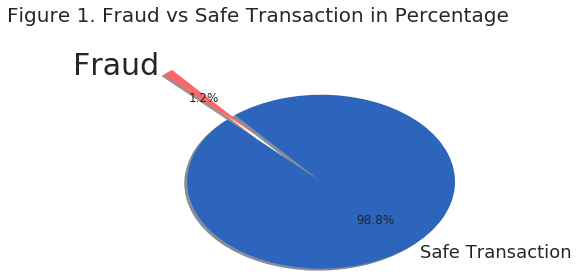



_ _ _ _ _ _ _ _ _ _  COLUMN INFORMATION & PREVIEW _ _ _ _ _ _ _ _ _ _ 



Total # of Values: 594643 
Shape: (594643, 8) 


         Parameter Nature # of Unique Entries                   Sample Entries (First three values)
step      Feature          180                 0, 1, 2                                             
customer  Feature          4112                'C1093826151', 'C352968107', 'C2054744914'          
age       Feature          8                   '4', '2', '3'                                       
gender    Feature          4                   'M', 'F', 'E'                                       
merchant  Feature          50                  'M348934600', 'M1823072687', 'M50039827'            
category  Feature          15                  'es_transportation', 'es_health', 'es_otherservices'
amount    Feature          23767               4.55, 39.68, 26.89                                  
fraud     Target           2                   0, 1                        

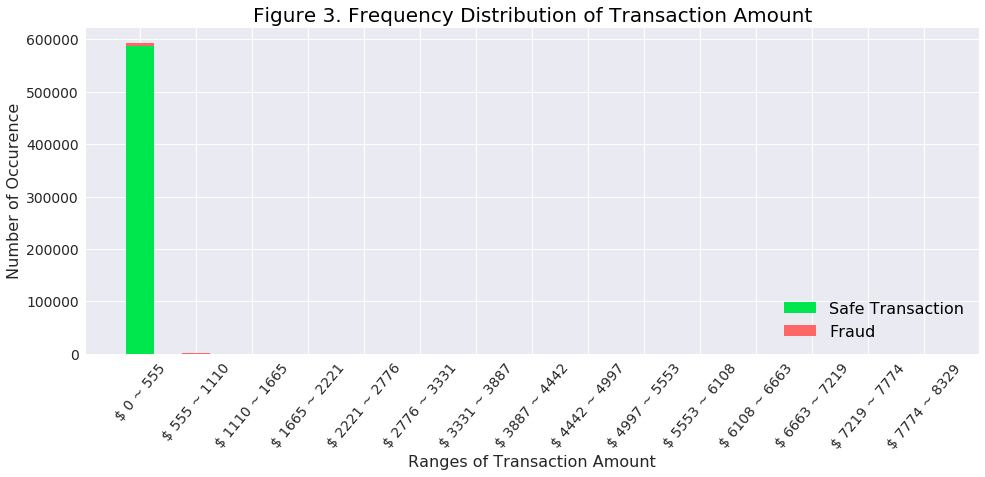



_ _ _ _ _ _ _ _ _ _  FRAUD PERCENTAGE AT DIFFERENT RANGES OF TRANSACTION AMOUNT _ _ _ _ _ _ _ _ _ _ 




<Figure size 432x432 with 0 Axes>

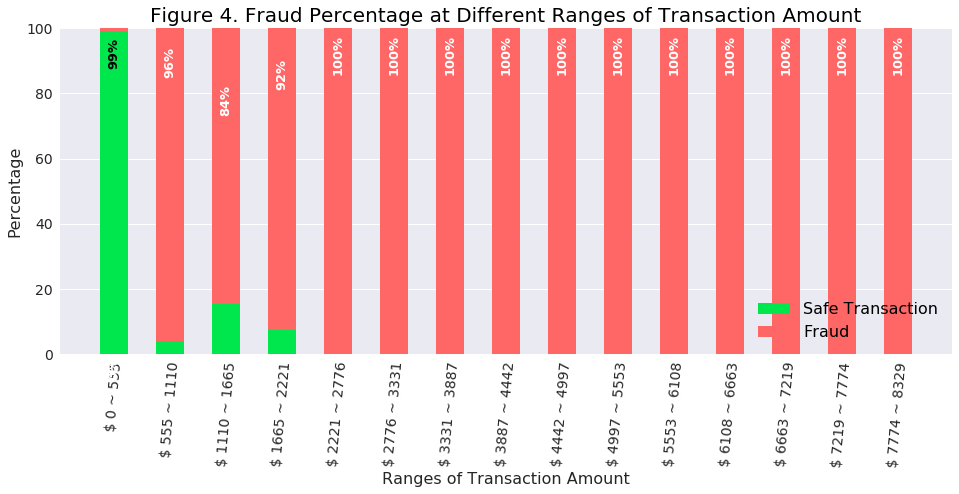



_ _ _ _ _ _ _ _ _ _  FRAUD VS NON-FRAUD HISTOGRAM _ _ _ _ _ _ _ _ _ _ 




No handles with labels found to put in legend.


<Figure size 432x432 with 0 Axes>

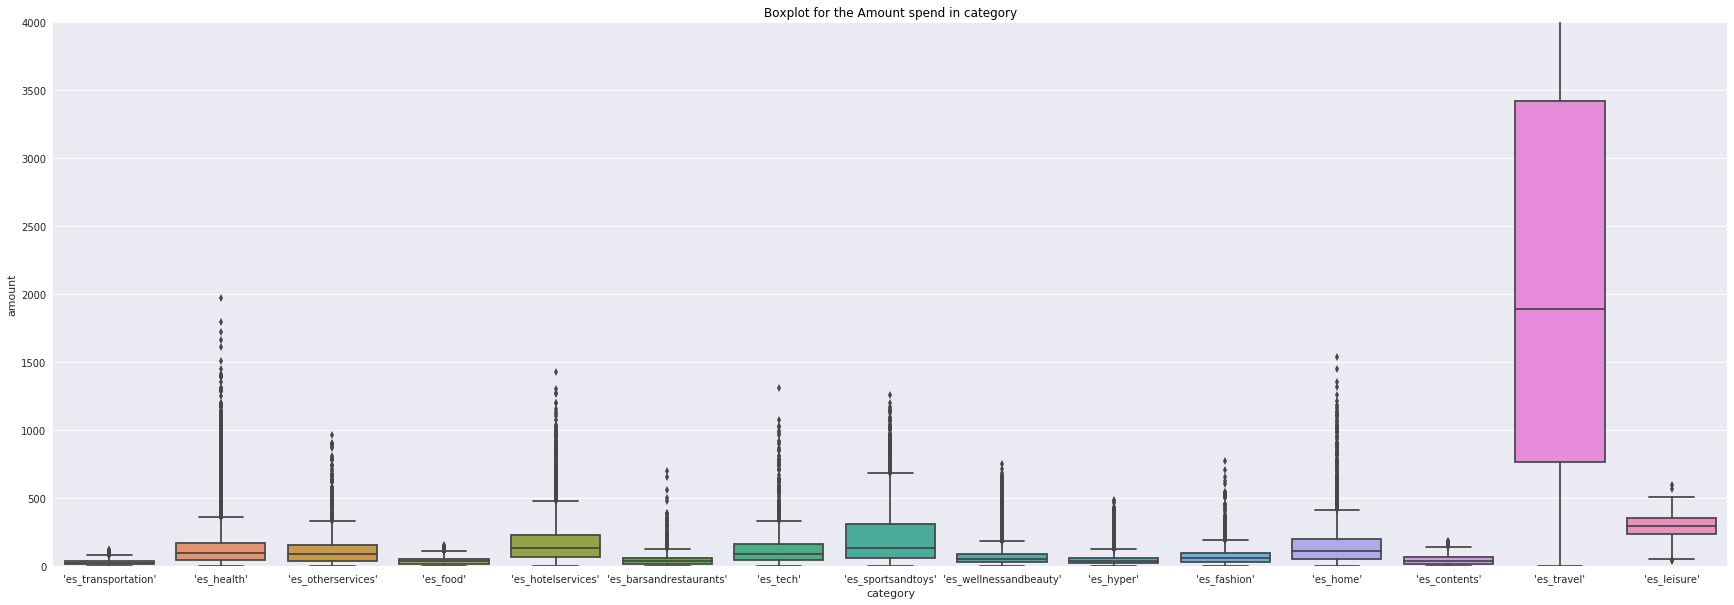



_ _ _ _ _ _ _ _ _ _  FRAUD DISTRIBUTION PER AGE _ _ _ _ _ _ _ _ _ _ 


  Age    Label  # of Fraud
1  0   <=18     48        
4  1   19-25    689       
7  2   26-35    2344      
6  3   36-45    1755      
5  4   46-55    1410      
3  5   56-65    686       
2  6   >65      261       
0  U   Unknown  7         


_ _ _ _ _ _ _ _ _ _  CATEGORICAL VALUES TO NUMERICAL - HASHMAP GENERATION _ _ _ _ _ _ _ _ _ _ 


Features Types: 

step        int64  
customer    object 
age         object 
gender      object 
merchant    object 
category    object 
amount      float64
fraud       int64  
dtype: object


Categorical Features: Index(['customer', 'age', 'gender', 'merchant', 'category'], dtype='object')



Hash maps previews:



/home/ec2-user/anaconda3/envs/verafin-mitacs-2020/lib/python3.6/site-packages/ipykernel_launcher.py:164: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)


__________ customer __________ 
    Index          Label
0  210    'C1093826151'
1  2753   'C352968107' 
2  2285   'C2054744914'
3  1650   'C1760612790'
4  3585   'C757503768' 
__________ age __________ 
    Index Label
0  4      '4' 
1  2      '2' 
3  3      '3' 
4  5      '5' 
6  1      '1' 
__________ gender __________ 
      Index Label
0    2      'M' 
2    1      'F' 
467  0      'E' 
586  3      'U' 
__________ merchant __________ 
     Index          Label
0   30     'M348934600' 
2   18     'M1823072687'
12  36     'M50039827'  
40  22     'M1888755466'
42  0      'M1053599405'
__________ category __________ 
      Index                Label
0    12     'es_transportation'
12   4      'es_health'        
40   9      'es_otherservices' 
77   3      'es_food'          
127  6      'es_hotelservices' 


_ _ _ _ _ _ _ _ _ _  FEATURE IMPORTANCE _ _ _ _ _ _ _ _ _ _ 




DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, 

<Figure size 432x432 with 0 Axes>

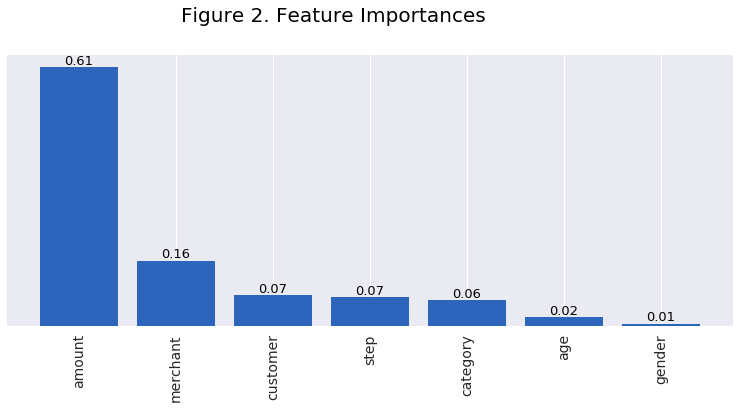



_ _ _ _ _ _ _ _ _ _  VISUALIZATION BEFORE TRANSFORMATION _ _ _ _ _ _ _ _ _ _ 


Total Fraud vs Non-Fraud Transactions Count: 

0    587443
1    7200  
Name: fraud, dtype: int64

Number of customers:  4112
Ratio of positive frauds vs total dataset: 1.21%

Transactions per customer.
	Mean: 144.6
	Max:  265 
	Number of Batches Using Max Amount as Fixed Size: 2243.9 ~ 2244
	Number of Batches Using Mean Amount as Fixed Size: 4112.0 ~ 4112


Samples per Step (day): 
	Mean: 3304 
	Max: 3774 
	Number of Batches Using Max Amount as Fixed Size: 157.6 ~ 158
	Number of Batches Using Mean Amount as Fixed Size: 180.0 ~ 180


_ _ _ _ _ _ _ _ _ _  GROUPING TRANSACTIONS BY CUSTOMER ID _ _ _ _ _ _ _ _ _ _ 


LEN:  4112
# Feaures:  8
MIN TRANS PER CUST:  5
MEAN TRANS PER CUST:  144.61162451361866  ~  145
MAX TRANS PER CUST:  265
EXAMPLE: 

         step  customer  age  gender  merchant  category  amount  fraud
80563   30    0         5    2       22        9         143.87  0    
105386  38    0       

<Figure size 432x432 with 0 Axes>

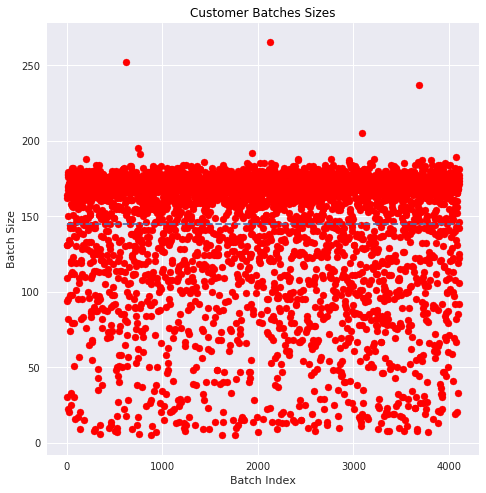



BOX PLOT SHOWING MEAN SIZE OF BATCHES GROUPED BY CUSTOMER ID: 




<Figure size 432x432 with 0 Axes>

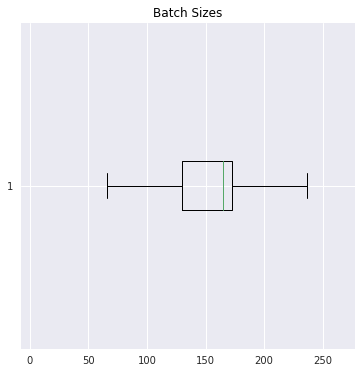



_ _ _ _ _ _ _ _ _ _  GENERATING 3D INPUT WITH BATCHES OF SIZE 265 _ _ _ _ _ _ _ _ _ _ 



      The batches are separated by customer id. To be able to use the batches as input for the RNN, 
      it needs to have a static size. That is why the batch size is defined by the max number of 
      transactions done by the customers (265). If one of the customers have done less transactions,
      the rest of the empty space is filled with 0 values. The final array size is (4112, 265, 8).

 
Total Empty Rows Added:  495037 
Percentage of Empty Rows Added Compared to Total # of Data Points: % 45.43 
New Shape:  (4112, 265, 8) 
Mean of frauds per batch:  0.00024 
Percentage of frauds per batch:  9e-05


_ _ _ _ _ _ _ _ _ _  GENERATING 3D INPUT WITH BATCHES OF SIZE 145 _ _ _ _ _ _ _ _ _ _ 



      The batches are separated by customer id. To be able to use the batches as input for the RNN, 
      it needs to have a static size. That is why the batch size is defined by the average number of 

/home/ec2-user/anaconda3/envs/verafin-mitacs-2020/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ec2-user/anaconda3/envs/verafin-mitacs-2020/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ec2-user/anaconda3/envs/verafin-mitacs-2020/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice.
 99% (4111 of 4112) |################### | Elapsed Time: 2:32:59 ETA:   0:00:07

--- 9181.32 s seconds or 153.02 minutes ---
(4112, 265, 13)
[[30.  5.  2. ... -1. -1.  0.]
 [38.  5.  2. ...  9. 22.  0.]
 [42.  5.  2. ...  9. 15.  0.]
 ...
 [ 0.  0.  0. ... 12. 18.  0.]
 [ 0.  0.  0. ... 12. 18.  0.]
 [ 0.  0.  0. ... 12. 18.  0.]]


_ _ _ _ _ _ _ _ _ _  SEPARATING X & y FOR TRAINING _ _ _ _ _ _ _ _ _ _ 


X Shape: (4112, 265, 12) Y Shape: (4112, 265)


_ _ _ _ _ _ _ _ _ _  SEPARATING TEST & TRAIN _ _ _ _ _ _ _ _ _ _ 


Converting 3D to 2D for easy processing. Batch Sample: 

 [[30.  5.  2. ...  1. -1. -1.]
 [38.  5.  2. ...  1.  9. 22.]
 [42.  5.  2. ...  0.  9. 15.]
 ...
 [ 0.  0.  0. ...  0. 12. 18.]
 [ 0.  0.  0. ...  0. 12. 18.]
 [ 0.  0.  0. ...  0. 12. 18.]] 

 Original Array Shape: (4112, 265, 12). Temporary array with shape: (1089680, 12)

Data Normalized and reshaped to a 3D array. Current Shape: (4112, 265, 12). 

Batch Sample: 

 [[0.16759777 0.71428571 0.66666667 ... 1.         0.         0.        ]
 [0.2122905  0.71428571 0.66666667 ... 1.         0.6

<Figure size 432x432 with 0 Axes>

In [84]:
# %%capture output

X_train, X_test, y_train, y_test, labels_hash = None, None, None, None, None

if(generate_data):
  X_train, X_test, y_train, y_test, labels_hash = generateData(save_to_cloud)
else:
  X_train, X_test, y_train, y_test, labels_hash = readDataFromCloud()

In [85]:
n_batches        = X_train.shape[0]
batch_size       = X_train.shape[1]
n_features       = X_train.shape[2]
n_pred_per_batch = y_train.shape[1]
rnn = RNNModel(
  input_shape=( batch_size , n_features  ),
  output_dim = n_pred_per_batch,
  param_grid={
    "rnn_hidden_layers" : [1], 
    "rnn_hidden_layers_neurons" : [100], 
    "hidden_layers" : [0], 
    "hidden_layers_neurons" : [150], 
    "loss" : ["mse"],       #['binary_crossentropy'], 
    "optimizer" : ['adam'],
    "modelType" : ['LSTM'],
    "epochs"    : [2]
  },
  scoring=None, refit=True, verbose=2
)



_ _ _ _ _ _ _ _ _ _  INITIALIZING GRID SEARCH RNN MODEL _ _ _ _ _ _ _ _ _ _ 


PARAMETERS:
________________________________
input_shape: (265, 12)
output_dim: 265
rnn_hidden_layers : [1]
rnn_hidden_layers_neurons : [100]
hidden_layers : [0]
hidden_layers_neurons : [150]
loss : ['mse']
optimizer : ['adam']
modelType : ['LSTM']
epochs : [2]





In [ ]:
# %%capture output

history = rnn.train( 
  X_train, y_train, X_test, y_test,
  output_file= model_name
)



_ _ _ _ _ _ _ _ _ _  TRAINING RNN _ _ _ _ _ _ _ _ _ _ 




Class weights: [ 0.50332573 75.67155756] 
for classes: [0. 1.] 
# Frauds: 5759, 
# of Non-Frauds: 865826


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
cv_results_df = pd.DataFrame(history.cv_results_).round(3)

for i, cvr in enumerate(cv_results_df.iterrows()):
  print("""{} MODEL # {} {}\n
PARAM EPOCHS    :  {} HIDDEN LAYERS  :  {}   NEURONS PER HIDDEN LAYER:  {} 
LOSS FUNCTION   : "{}" MODEL TYPE     : "{}" OPTIMIZER        : "{}"
STD FIT TIME    :  {} MEAN SCORE TIME:  {} STD SCORE TIME   :   {} 
MEAN TEST SCORE :  {} STD TEST SCORE :  {} RANK TEST SCORE  :   {} 
MEAN TRAIN SCORE:  {} STD TRAIN SCORE:  {} 
PARAMS: {}      
""".format(
    10*" _" , i+1, 10*" _", 
    cv_results_df.at[i, "param_epochs"]     , cv_results_df.at[i, "param_hidden_layers"]  , cv_results_df.at[i, "param_hidden_layers_neurons"], cv_results_df.at[i, "param_rnn_hidden_layers"] ,  cv_results_df.at[i, "param_rnn_hidden_layers_neurons"] , 
    cv_results_df.at[i, "param_loss"]       , cv_results_df.at[i, "param_modelType"]      , cv_results_df.at[i, "param_optimizer"]            ,
    cv_results_df.at[i, "std_fit_time"]     , cv_results_df.at[i, "mean_score_time"]      , cv_results_df.at[i, "std_score_time"]             ,                                                                                                                      
    cv_results_df.at[i, "mean_test_score"]  , cv_results_df.at[i, "std_test_score"]       , cv_results_df.at[i, "rank_test_score"]            ,
    cv_results_df.at[i, "mean_train_score"] , cv_results_df.at[i, "std_train_score"]      ,
    cv_results_df.at[i, "params"]                     
  ))
  train_score_p_split = [ cv_results_df.at[i,"split{}_train_score".format(j)] for j in range(10) ]
  test_score_p_split  = [ cv_results_df.at[i,"split{}_test_score".format(j)] for j in range(10) ]
  index_titles = ["TRAIN", "TEST"]

  print("""PERFORMANCE PER SPLIT \n\n{}
  \n\n""".format( pd.DataFrame([ np.round(train_score_p_split, 3) , np.round(test_score_p_split, 3) ], 
    columns=[ "SPLIT#{}".format(se ) for se in range(10)],
    index=index_titles
  ) ))
  
  plt.plot(train_score_p_split)
  plt.plot(test_score_p_split)
  plt.title('model accuracy')
  plt.suptitle( str(cv_results_df.at[i, "params"])  )
  plt.ylabel('accuracy')
  plt.xlabel('split')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  img_name ="Model#{}_{}".format(i+1, str(cv_results_df.at[i, "params"]).upper())
  for rt in ['{', '}', '\'', ' ', ':', ',' ]:
    img_name = img_name.replace( rt, '_')
  print("\n\nSaving image with name: ",  img_name )
  plt.savefig( img_name)
  print("\n\n")

In [ ]:
selected_epochs = history.cv_results_["params"][0]['epochs']
print("""\n\nBEST MODEL HISTORY PER EPOCH
SELECTED EPOCHS   : {}
PARAMS            : {} \n""".format( 
  selected_epochs,
  history.best_params_
))

index_names = ["acc", "val_acc", "loss", "val_loss"]
index_titles = ["TRAIN ACC", "TEST ACC", "TRAIN LOSS", "TEST LOSS"]
print( pd.DataFrame([ np.round( history.best_estimator_.model.history.history[iname] , 3) for iname in index_names], 
  columns=[ "EPOCH#{}".format(se+1) for se in range(selected_epochs)],
  index=index_titles
), "\n")

# summarize history for accuracy
plt.plot(history.best_estimator_.model.history.history['acc'])
plt.plot(history.best_estimator_.model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig( 'BEST MODEL ACC' )
print("\n\n")
# summarize history for loss
plt.plot(history.best_estimator_.model.history.history['loss'])
plt.plot(history.best_estimator_.model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig( 'BEST MODEL LOSS' )

In [24]:
!ls *.data

labels_hash.data


In [ ]:
 saveToCloud( X_train, X_test, y_train, y_test, labels_hash )